# Train a RNN model

**Authors:** CHRETIEN Jérémy, DAVIDSON Colin, LAFAGE Adrien, REMBUSCH Gabrielle and WILBRINK Aurore.

In [1]:
import nltk
from nltk.corpus import stopwords as stpw

import numpy as np
import pandas as pd

import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# nltk.download('stopwords')

Hyperparameters

In [2]:
BATCH_SIZE = 64
MAX_FEATURES = 20000
SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 128

### Get the dataset



In [3]:
start = time.time()
train_df = pd.read_csv("./data/cleaned_train_dataset.csv")
test_df = pd.read_csv("./data/cleaned_test_dataset.csv")

print(f"Loading Duration: {time.time() - start}s")
train_df

Loading Duration: 0.25255274772644043s


label                                           features
0          1  pure byte fragile beautiful amazing represente...
1          0  marry cousin forbid raised allows marry bored ...
2          0  gourgous malthe sector tivo disk warehouse por...
3          0  distinct misfortune catching worst morning inc...
4          1  excellent traditional northern bolton mason do...
...      ...                                                ...
24995      0  disappointment bad bad sadly embarrassed poor ...
24996      0  wrong love suchet poirot love nile suchet awes...
24997      1  agree taximeter fantastic wide imagination dis...
24998      0  boring snippet flesh tossed lame awake succeed...
24999      1  good good disappointed disappointed read eleme...

[25000 rows x 2 columns]

### Get the vocabulary

In [4]:
start = time.time()

tfidf = TfidfVectorizer(
    max_features=MAX_FEATURES,
    # stop_words=set(stpw.words("english")),
    lowercase=False,
)

tfidf.fit(train_df.features)

vocabulary = list(tfidf.vocabulary_.keys())
print(f"Get vocabulary in {time.time() - start}s")
print(len(tfidf.vocabulary_))

Get vocabulary in 2.1603286266326904s
20000


### Generate `tf.data.Dataset` from the `pd.Dataframes`

In [5]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train_df.features.values, tf.string),
            tf.cast(train_df.label.values, tf.int32)
        )
    )
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(test_df.features.values, tf.string),
            tf.cast(test_df.label.values, tf.int32)
        )
    )
)

### Shuffle and batch the dataset

In [6]:
train_dataset = train_dataset.shuffle(len(train_df)).batch(BATCH_SIZE)

test_dataset = test_dataset.shuffle(len(test_df)).batch(BATCH_SIZE)

Print the first five instances of one batch.

In [7]:
for text_batch, label_batch in train_dataset.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b'funding inject jeff goldblum fly manages semblance sanity succumbs experiment pretty bad stupidly danger apparent lab forbidden enter admittedly good pretty waste tyrannosaurus rack trek convention'
0
b'bewitchingly sweet love inspiration successful bewitched lovely sweet romcom timeless treasure comparison stewart hapless stolid kim novac voluptuous blond capture love spell spell broken stronger duty comfort beloved pyewacket feline familiar cared beloved aunt recognize aunt fun touchingly sweet bearing spectacular wit nice witchy'
1
b'cubitt shallow cubitt fantastic mildlyi read site drawn cubitt theo colm feore ryan believable estranged theo ryan gay brilliantly ryan noticing hasthe researched incredibly uplifting celebration ryan knowledge unconditional love ex addict theo agree theo vocalised ryan cruelly theo theo theo exchange speaks volume self pitying ryan sharply retorta brilliantly conceived loved superbly infinite degree respect outpouring love contrite mawkish speaks vol

### Vectorize the data

In [8]:
text_data = train_dataset.map(lambda x, y: x)

vectorize_layer = TextVectorization(
    standardize = None,
    output_mode = "int",
    output_sequence_length=SEQUENCE_LENGTH
)

vectorize_layer.set_vocabulary(vocabulary)

In [9]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [10]:
train_dataset = train_dataset.map(vectorize_text)
test_dataset = test_dataset.map(vectorize_text)

Computation optimization

In [11]:
train_dataset = train_dataset.cache().prefetch(buffer_size=10)
test_dataset = test_dataset.cache().prefetch(buffer_size=10)

### Build the model

In [12]:
inputs = tf.keras.Input(shape=(None,), dtype='int64')
# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(MAX_FEATURES+2, EMBEDDING_DIM)(inputs)
x = layers.Dropout(0.5)(x)

# LSTM layer
x = layers.Bidirectional(layers.LSTM(128))(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

### Train the model

In [13]:
# Fit the model using the train and test datasets.
history = model.fit(train_dataset, validation_data=test_dataset, epochs=2)

Epoch 1/2
391/391 [==============================] - 708s 2s/step - loss: 0.5218 - accuracy: 0.7393 - val_loss: 0.3881 - val_accuracy: 0.8424
Epoch 2/2
391/391 [==============================] - 886s 2s/step - loss: 0.2947 - accuracy: 0.8904 - val_loss: 0.3581 - val_accuracy: 0.8538


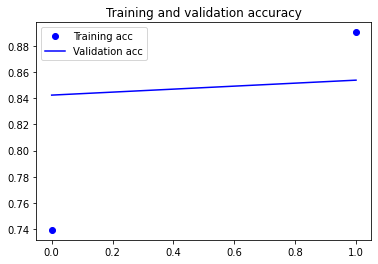

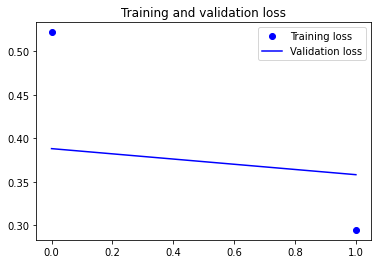

In [14]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Results

We succeed with this network to achieve 85% of accuracy on the validation set. It could have been interesting to try out some other network architectures with more layers for instance, but we are too limited by our computer capacity to do it.